In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'plant-village:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F414960%2F793497%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240803%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240803T091429Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D7ac3cc9e8a26610489f00016789542718529004867dcc7069e6fd438e84c79a5ac3e4910f40e3ad6a102f3d3ace37fae2514561a2e5c148fd78b140d28f52c9691cf7a007c0b0efebc2eaa27aa8c5c95aa3dd265e12b09a031e5a63fdd2f3a621f46ad3b3fc43c24db8c401e5b558802890798f1d5aecf848047a56b776d5ef4bddc568a3bfe1ff2cfaf2c5c429024714c7252e1e86f93b02ff389f240020fec3fac3b764adb0760c8eacfb26f16e3c831dd5a493d44a2e6ad04761aa58553aaef14f0ad7d159bd33a01e59cdea6a74b7cdbb32d0ec1d5bcffeb37aa32fb772c59b2d74d2b6cf1065352e722e2be1b7519fbfdec503f0d9a3a47022a9c328a25'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 344488049 bytes downloaded
Downloaded and uncompressed: plant-village
Data source import complete.


# Problem Statement
Farmers every year face economic loss and crop waste due to various diseases in potato plants.  Early blight and Late blight are major disease of potato leaf. It is estimated that the major loss occurred in potato yield is due to these diseases. Thus the images are classified into 3 classes :
- Healthy leaves     
<img src="https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Ftse1.mm.bing.net%2Fth%3Fid%3DOIP.jW152ASG2nfRv_LCkYnzMQHaFj%26pid%3DApi&f=1" height='200' width="300"/>

- Late Blight leaves
<img src="https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Ftse2.mm.bing.net%2Fth%3Fid%3DOIP.vCrNUKDj1Z1zErHEMQzmCQHaFj%26pid%3DApi&f=1" height='200' width="300"/>

- Early Blight leaves
<img src="https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Ftse2.mm.bing.net%2Fth%3Fid%3DOIP.e4wvw_JVbE1yFgOYbUoVSAHaE7%26pid%3DApi&f=1" height='200' width="300"/>

Project inspiration : https://youtube.com/playlist?list=PLeo1K3hjS3utJFNGyBpIvjWgSDY0eOE8S

In [2]:
# import libraries
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # to disable all debugging logs

In [3]:
# importing dataset
dir = os.listdir('../input/plant-village/PlantVillage')
for filenames in dir:
    print(filenames)

Potato___Early_blight
Tomato_Spider_mites_Two_spotted_spider_mite
Potato___Late_blight
Tomato_Septoria_leaf_spot
Pepper__bell___healthy
Tomato_Early_blight
Tomato_Leaf_Mold
Tomato__Target_Spot
Pepper__bell___Bacterial_spot
Potato___healthy
Tomato_Late_blight
Tomato_Bacterial_spot
Tomato_healthy
Tomato__Tomato_YellowLeaf__Curl_Virus
Tomato__Tomato_mosaic_virus


# Extracting only potato dataset

In [4]:
!cp -rf ../input/plant-village/PlantVillage/Potato___Early_blight ./Potato___Early_blight

In [5]:
!cp -rf ../input/plant-village/PlantVillage/Potato___Late_blight ./Potato___Late_blight

In [6]:
!cp -rf ../input/plant-village/PlantVillage/Potato___healthy ./Potato___healthy

In [7]:
Current_Dir = os.getcwd()
dataset_dir = pathlib.Path(Current_Dir)
print(dataset_dir)

/content


In [8]:
#Global initialization of some imp variables
Image_Size = 256
Batch_Size = 32
Channels = 3
Epochs = 40


In [9]:
#yields batches of images from the subdirectories class_a , class_b and class_c
#together with labels 0 , 1 and 2 (0, 1, 2 corresponding to classes class_a , class_b and class_c respectively )
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir, batch_size = Batch_Size, image_size = (Image_Size, Image_Size), shuffle = True)

Found 2152 files belonging to 4 classes.


In [10]:
#Folders(classes) in 'Dataset' directory
class_name = dataset.class_names
class_name

['Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'sample_data']

In [11]:
len(dataset) # Number of Batches = (total number of files belonging to all classes / Batch_Size)

68

In [12]:
print(dataset) #prints Elements in dataset: here 1st element is image and 2nd index of that image.

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


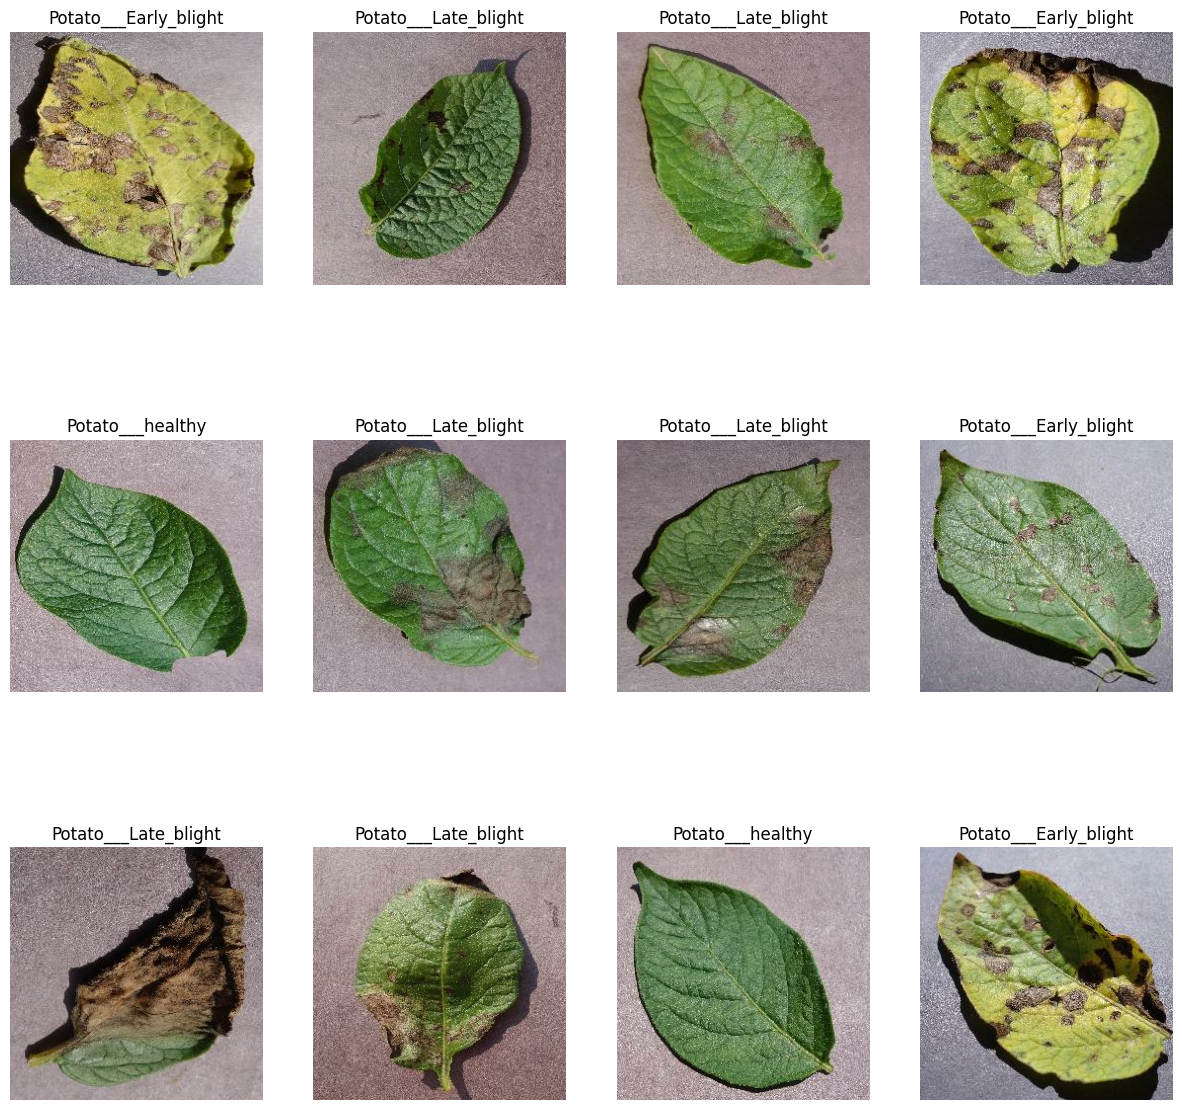

In [13]:
# Plotting the image
plt.figure(figsize = (15,15))
# dataset.take(count) : Creates a Dataset with at most 'count' elements(batch) from the dataset
for image, label in dataset.take(1):
    for i in range(12):
        plt.subplot(3, 4, i+1) # many plots at a time =>subpots
        plt.imshow(image[i].numpy().astype('uint8')) #converting all data of image into numpy and than to intiger type as they were in float.
        plt.title(class_name[label[i]])  # title of the class_name of image
        plt.axis("off") # Hide the values of graph


# Splitting Dataset

In [14]:
# Function for Splitting the data
def split_dataset(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 10)

    ds_size = len(ds)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [15]:
train_data, val_data, test_data = split_dataset(dataset)

In [16]:
print("Size of Data is :{0} \nBatch size of Training Data is :{1}\nBatch size of Validation Data is :{2} \nBatch size of Testing Data is :{3} " .format(len(dataset), len(train_data), len(val_data), len(test_data)))

Size of Data is :68 
Batch size of Training Data is :54
Batch size of Validation Data is :6 
Batch size of Testing Data is :8 


In [17]:
# caching,shuffle and prefetching the data
train_ds = train_data.cache().shuffle(100).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_data.cache().shuffle(100).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_data.cache().shuffle(100).prefetch(buffer_size = tf.data.AUTOTUNE)

# Data Pre-processing

In [18]:
# Image Preprocessing : Rescaling and Resizing
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(Image_Size, Image_Size),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [19]:
# Data augmentation by flipping and rotating existing images
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(factor = 0.5)
])

# Model Building

In [20]:
# Creating Convolution layer
input_shape = (Batch_Size, Image_Size, Image_Size, Channels)
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(filters = 16, kernel_size = (3,3), activation = 'relu', input_shape = input_shape),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(128, (3,3), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(128, (3,3), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.Flatten(),
    layers.Dense(128, activation = 'relu'),
    layers.Dense(64, activation = 'softmax'),

])


model.build(input_shape = input_shape)

In [21]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        9280      
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [22]:
# Optimizing the model 'SparseCategoricalCrossentropy'=>as there are many categorical classes of data
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy'])

In [23]:
#Fit the model with training data and also pass validation data
history = model.fit(
train_data, epochs = Epochs, batch_size = Batch_Size, verbose = 1, validation_data = val_data)

Epoch 1/40
54/54 [==============================] - 25s 425ms/step - loss: 1.2079 - accuracy: 0.4619 - val_loss: 0.8770 - val_accuracy: 0.5260
Epoch 2/40
54/54 [==============================] - 23s 418ms/step - loss: 0.8595 - accuracy: 0.5921 - val_loss: 0.6902 - val_accuracy: 0.7500
Epoch 3/40
54/54 [==============================] - 23s 422ms/step - loss: 0.6439 - accuracy: 0.7130 - val_loss: 0.6517 - val_accuracy: 0.6771
Epoch 4/40
54/54 [==============================] - 23s 421ms/step - loss: 0.4905 - accuracy: 0.7964 - val_loss: 0.6176 - val_accuracy: 0.7292
Epoch 5/40
54/54 [==============================] - 23s 418ms/step - loss: 0.3496 - accuracy: 0.8457 - val_loss: 0.3554 - val_accuracy: 0.8542
Epoch 6/40
54/54 [==============================] - 23s 414ms/step - loss: 0.2692 - accuracy: 0.8932 - val_loss: 0.3112 - val_accuracy: 0.9107
Epoch 7/40
54/54 [==============================] - 23s 423ms/step - loss: 0.2364 - accuracy: 0.9043 - val_loss: 0.1906 - val_accuracy: 0.9271

In [24]:
scores = model.evaluate(train_data)

54/54 [==============================] - 4s 79ms/step - loss: 0.0611 - accuracy: 0.9806


In [25]:
history

In [26]:
history.params

{'verbose': 1, 'epochs': 40, 'steps': 54}

In [27]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

# Analyzing the Output

In [28]:
# Getting the model history to analyse
train_loss = history.history['loss']
train_acc = history.history['accuracy']

val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']


Text(0.5, 1.0, 'Training and Validation Loss')

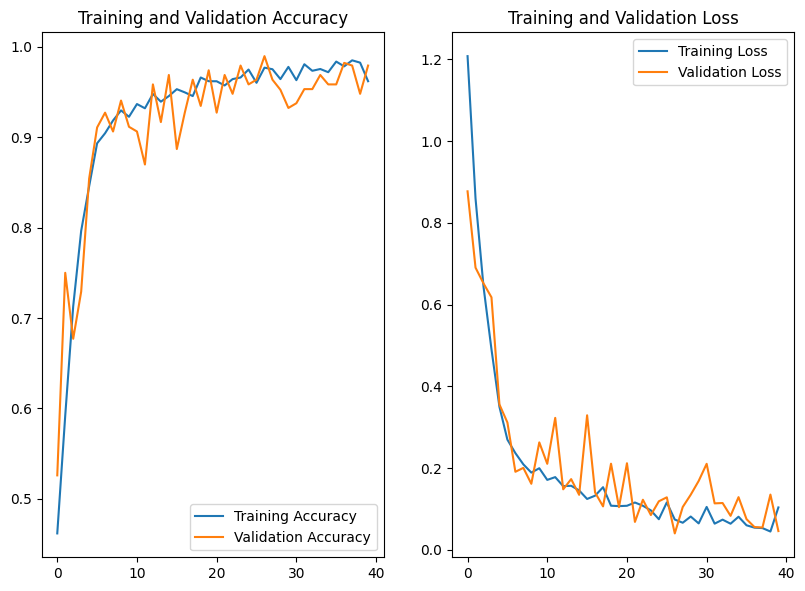

In [29]:
#graphs for accuracy and loss of training and validation data
plt.figure(figsize = (15,15))
plt.subplot(2,3,1)
plt.plot(range(Epochs), train_acc, label = 'Training Accuracy')
plt.plot(range(Epochs), val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2,3,2)
plt.plot(range(Epochs), train_loss, label = 'Training Loss')
plt.plot(range(Epochs), val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')

First Image of batch to predict :
Actual label :  Potato___Early_blight
1/1 [==============================] - 0s 111ms/step
Predicted label :  Potato___Early_blight


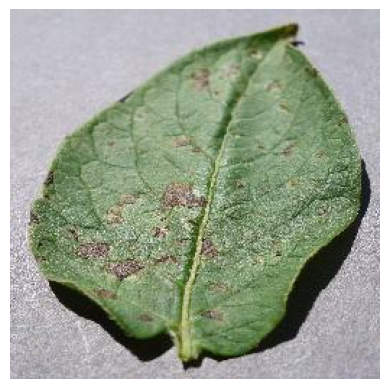

In [32]:
#plotting image
for batch_image, batch_label in train_data.take(1):
    first_image = batch_image[0].numpy().astype('uint8')
    first_label = class_name[batch_label[0]]

    print('First Image of batch to predict :')
    plt.imshow(first_image)
    print('Actual label : ', first_label)

    batch_prediction = model.predict(batch_image)
    print('Predicted label : ', class_name[np.argmax(batch_prediction[0])])
    plt.axis('off')

1/1 [==============================] - 0s 109ms/step


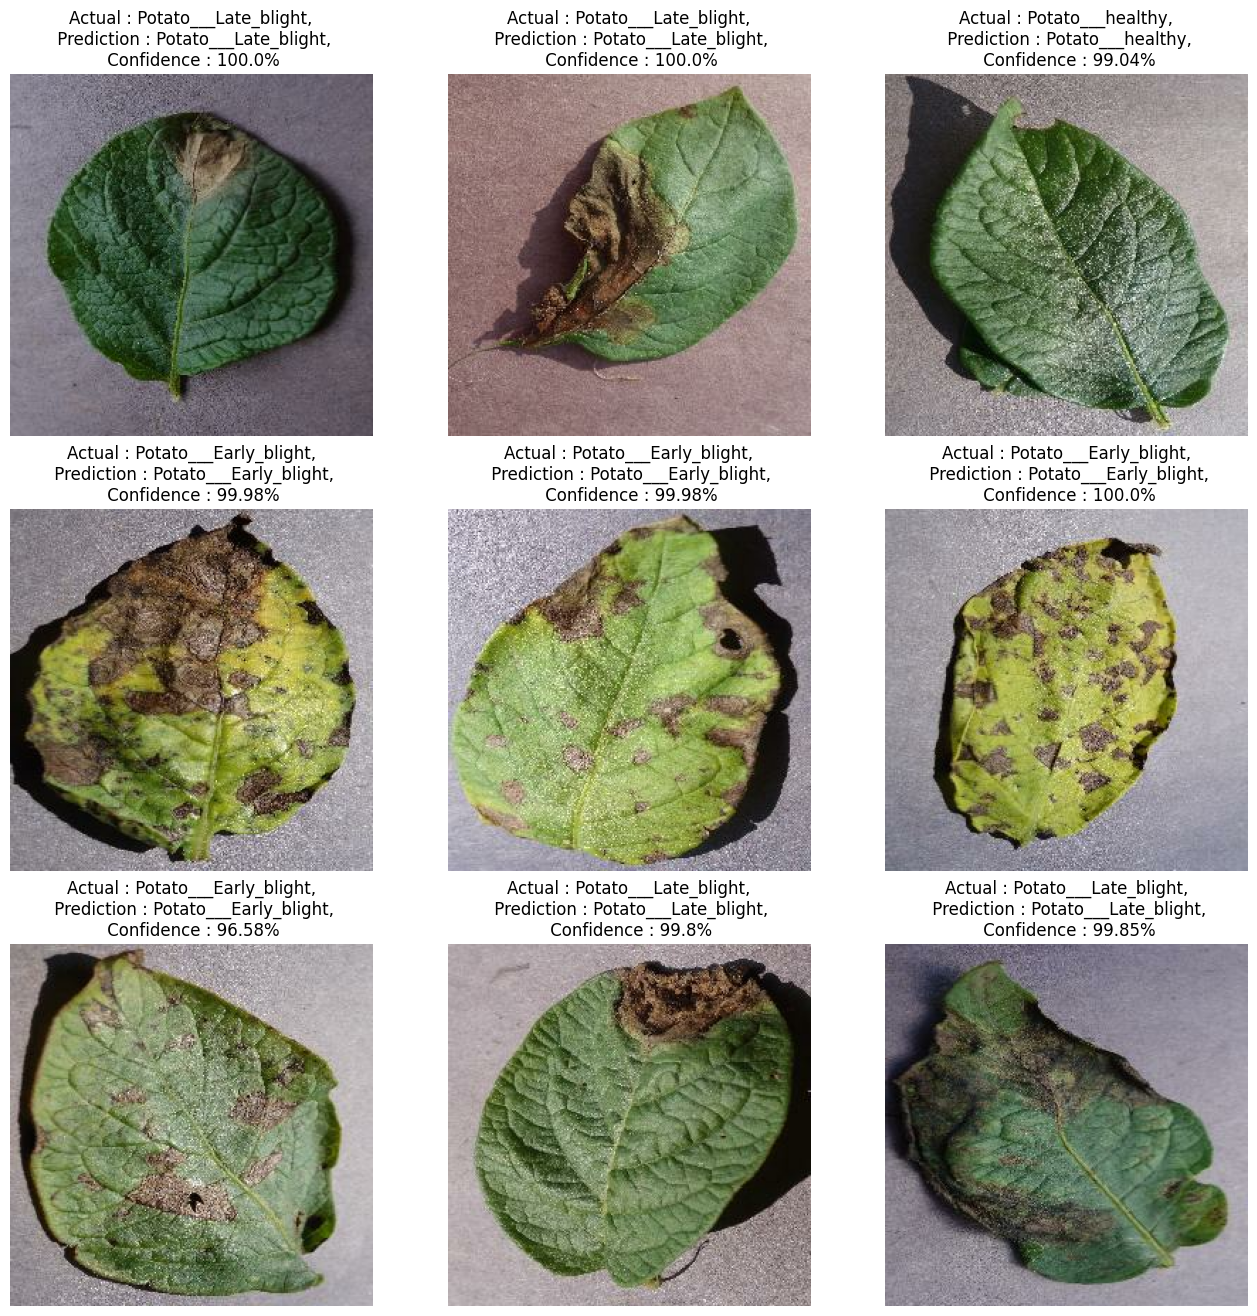

In [31]:
# plotting batch of images with its actual label, predicted label and confidence
plt.figure(figsize = (16,16))
for batch_image, batch_label in train_data.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        image = batch_image[i].numpy().astype('uint8')
        label = class_name[batch_label[i]]

        plt.imshow(image)

        batch_prediction = model.predict(batch_image)
        predicted_class = class_name[np.argmax(batch_prediction[i])]
        confidence = round(np.max(batch_prediction[i]) * 100, 2)

        plt.title(f'Actual : {label},\n Prediction : {predicted_class},\n Confidence : {confidence}%')

        plt.axis('off')

### The Model shows accuracy > 97%

In [39]:
test_images = np.array([image for image, label in test_data])  # Convert to array if not already
test_labels = np.array([label for image, label in test_data])  # Convert to array if not already
print(f"test_images shape: {test_images.shape}")


test_images shape: (8, 32, 256, 256, 3)


In [40]:
test_images, test_labels = [], []
for image, label in test_data:
    test_images.append(image.numpy())
    test_labels.append(label.numpy())
test_images = np.array(test_images)
test_labels = np.array(test_labels)


In [41]:
test_images = test_images.astype('float32')


In [53]:
from tensorflow.keras import layers, models

# Define the number of classes in your classification problem
num_classes = 10  # Adjust this to match your number of classes

# Example input shape
Image_Size = 128  # Example image size (height and width)
Channels = 3      # Example number of channels (e.g., RGB images)

input_shape = (Image_Size, Image_Size, Channels)  # Updated input shape (excluding batch size)

# Create the model
model = models.Sequential([
    # Rescaling and augmentation layers
    layers.Rescaling(1./255),  # Normalize pixel values to [0, 1]
    layers.RandomFlip("horizontal_and_vertical"),  # Data augmentation

    # Convolutional layers
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Global Average Pooling
    layers.GlobalAveragePooling2D(),

    # Fully connected (Dense) layers
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),  # Dropout for regularization
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),

    # Output layer with softmax activation for classification
    layers.Dense(num_classes, activation='softmax')
])

# Build the model with input shape (batch size not included)
model.build(input_shape=(None, Image_Size, Image_Size, Channels))

# Print the model summary
model.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 random_flip_5 (RandomFlip)  (None, 128, 128, 3)       0         
                                                                 
 conv2d_40 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_40 (MaxPooli  (None, 63, 63, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_41 (Conv2D)          (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_41 (MaxPooli  (None, 30, 30, 64)        0         
 ng2D)                                                

In [54]:
# Optimizing the model 'SparseCategoricalCrossentropy'=>as there are many categorical classes of data
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy'])

In [55]:
#Fit the model with training data and also pass validation data
history = model.fit(
train_data, epochs = Epochs, batch_size = Batch_Size, verbose = 1, validation_data = val_data)

Epoch 1/40
54/54 [==============================] - 36s 614ms/step - loss: 1.0656 - accuracy: 0.4456 - val_loss: 0.8979 - val_accuracy: 0.4323
Epoch 2/40
54/54 [==============================] - 33s 601ms/step - loss: 0.9346 - accuracy: 0.4877 - val_loss: 0.9786 - val_accuracy: 0.4167
Epoch 3/40
54/54 [==============================] - 33s 605ms/step - loss: 0.9165 - accuracy: 0.4883 - val_loss: 0.8134 - val_accuracy: 0.5677
Epoch 4/40
54/54 [==============================] - 32s 598ms/step - loss: 0.8167 - accuracy: 0.5669 - val_loss: 0.5670 - val_accuracy: 0.7604
Epoch 5/40
54/54 [==============================] - 32s 597ms/step - loss: 0.6552 - accuracy: 0.7195 - val_loss: 0.4902 - val_accuracy: 0.8333
Epoch 6/40
54/54 [==============================] - 32s 594ms/step - loss: 0.5254 - accuracy: 0.8122 - val_loss: 0.4372 - val_accuracy: 0.8490
Epoch 7/40
54/54 [==============================] - 32s 596ms/step - loss: 0.4617 - accuracy: 0.8345 - val_loss: 0.4040 - val_accuracy: 0.8490

In [59]:
scores = model.evaluate(train_data)

54/54 [==============================] - 7s 120ms/step - loss: 0.0345 - accuracy: 0.9871


In [66]:
import numpy as np
from sklearn.metrics import classification_report
import tensorflow as tf

# Define the number of classes
num_classes = 10  # Adjust this to match your number of classes

# Example input shape
Image_Size = 128  # Example image size (height and width)
Channels = 3      # Example number of channels (e.g., RGB images)

# Function to preprocess TensorFlow dataset
def preprocess_data(test_dataset):
    images = []
    labels = []
    for image, label in test_dataset:
        images.append(image.numpy())
        labels.append(label.numpy())
    images = np.array(images)
    labels = np.array(labels)
    images = images.astype('float32') / 255.0  # Normalize if necessary
    return images, labels

# Load your test dataset
# Example: Replace with your actual test dataset loading code
test_images = np.random.random((10, Image_Size, Image_Size, Channels))  # Replace with actual test images
test_labels = np.random.randint(0, num_classes, size=(10,))  # Replace with actual test labels
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
test_dataset = test_dataset.batch(32)  # Adjust batch size as needed

# Preprocess the test data
test_images, test_labels = preprocess_data(test_dataset)

# Make predictions
predictions = model.predict(val_data)
predicted_labels = np.argmax(predictions, axis=1)




6/6 [==============================] - 1s 129ms/step


In [ ]:
print("Classification Report:")
print(classification_report(test_labels, predicted_labels, target_names=[str(i) for i in range(num_classes)]))

In [67]:
print(num_classes)

10
